In [1]:
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

test_passIds = test[['PassengerId']]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [2]:
test_passIds

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


# Feature Engineering

## 1. Pclass
There is no missing value on this feature and already a numerical value. so let's check it's impact on our train set.

In [3]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex

In [4]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch
With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size

In [5]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


It seems has a good effect on our prediction but let's go further and categorize people to check whether they are alone in this ship or not

In [6]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


Good! the impact is considerable.

## 4. Embarked
The embarked feature has some missing value. and we try to fill those with the most occurred value ( 'S' ).

In [7]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [8]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


## 6. Age
We have plenty of missing values in this feature. # generate random numbers between (mean - std) and (mean + std). then we categorize age into 5 range.

In [9]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isna().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508772
1   (16.0, 32.0]  0.361607
2   (32.0, 48.0]  0.365462
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\Emincan\AppData\Local\Temp\ipykernel_26984\2819920955.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list


## 7.Name
Inside this feature we can find the title of people

In [10]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


so we have titles. let's categorize it and check the title impact on survival rate.

In [11]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Data Cleaning
Yes, now let's clean our data and map our features into numerical values

In [12]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    2     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


good! now we have a clean dataset and ready to predict. let's find which classifier works better on this dataset.

# Train | Test Split

In [13]:
from sklearn.model_selection import train_test_split

X = train[0::, 1::]
y = train[0::, 0]
X_train , X_test, y_train , y_test = train_test_split(X,y, test_size = 0.2 , random_state= 53 )

# Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Eval Metrics

In [15]:
from sklearn.metrics import accuracy_score, f1_score , precision_score , recall_score

def eval_metric(model, X_test, y_test):
    global acc, f1, prec, rec
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test , y_pred) 
    f1 = f1_score(y_test, y_pred)
    # mse = mean_squared_error(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test , y_pred)
    print(f"""
          Accuracy : {acc}
          F1 Score : {f1}
          Precision : {prec}
          Recall : {rec}
          """)

# 1) LazyPredict Model Comparision

In [16]:
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 48%|████▊     | 14/29 [00:00<00:00, 67.13it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


100%|██████████| 29/29 [00:00<00:00, 53.57it/s]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.83               0.80     0.80      0.82   
LGBMClassifier                     0.82               0.80     0.80      0.82   
BaggingClassifier                  0.80               0.79     0.79      0.80   
BernoulliNB                        0.80               0.79     0.79      0.80   
AdaBoostClassifier                 0.79               0.79     0.79      0.79   
NuSVC                              0.82               0.79     0.79      0.82   
LinearDiscriminantAnalysis         0.79               0.78     0.78      0.79   
CalibratedClassifierCV             0.79               0.78     0.78      0.79   
RidgeClassifierCV                  0.79               0.78     0

# 2) Like Lazy

<Axes: title={'center': 'Classifier Accuracy'}, xlabel='Accuracy', ylabel='Classifier'>

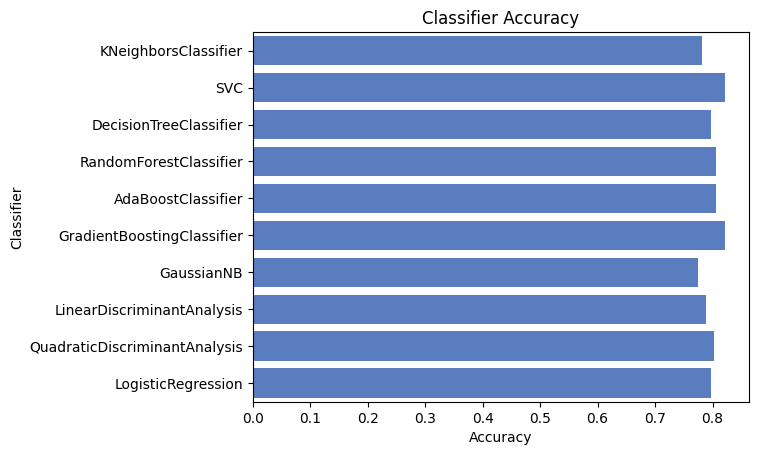

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = pd.concat([log,log_entry] , axis = 0)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Search Best Ensemble Models

In [18]:
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score , accuracy_score , precision_score , recall_score
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier , BaggingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier , cv , Pool
from lightgbm import LGBMClassifier
import warnings

In [19]:
models_comparison = {}
scoring = 'accuracy'
cv = 5
random_state = 53
n_iter = 30

# Random Search Models

### 1.Part Models

In [22]:
models = []
with tf.device('/GPU:0'):
    parameters = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.logspace(-1,2,20),
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 1000, 10000]
    }

    tmp_model = LogisticRegression()
    lr_model_random = RandomizedSearchCV(
        tmp_model, parameters, n_iter=n_iter, scoring=scoring, cv=cv
    )
    models.append(lr_model_random)

    parameters = {
    'learning_rate': np.arange(0.1,1,0.1),
    'n_estimators': [100, 250, 450, 600, 800, 1000],
    'estimator': [DecisionTreeClassifier(max_depth = 4) , DecisionTreeClassifier()]
    }
    tmp_model = AdaBoostClassifier()
    ada_model_random = RandomizedSearchCV(
        tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
    )
    models.append(ada_model_random)
       
    parameters = {
    'n_estimators': [80 , 100, 250, 450, 600, 800],
    'max_features': [1,2,3,5, 8 , 12 , 15 , None],
    'estimator': [DecisionTreeClassifier(max_depth = 4) , DecisionTreeClassifier()]
    }
    tmp_model = BaggingClassifier()
    bag_model_random = RandomizedSearchCV(
        tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
    )
    models.append(bag_model_random)

parameters = {
    "max_depth": [7, 10 , 15 , 25 , 35, None],
    "max_features": ["auto","sqrt", 10 , 15, None],
    "min_samples_split" : [2,3,5, 8],
    "splitter": ["best", "random"],
}
tmp_model = DecisionTreeClassifier()
dt_model_random = RandomizedSearchCV(
    tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(dt_model_random)

parameters = {
    "max_depth": [2, 5, 8, 10 , 15 , None],
    'n_estimators': [80, 150, 300, 500, 750 , 1000 , 1200, 1500],
    "min_samples_split" : [2,3,5],
    "max_features": [3, 5, 8, 12 , 15 , None],
}
tmp_model = RandomForestClassifier()
rf_model_random = RandomizedSearchCV(
    tmp_model, parameters, n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(rf_model_random)

parameters = {
    "weights": ["uniform", "distance"],
    'p' : [2,3,5,10, 15],
    'leaf_size' : [20,30,40,60,80,100],
    "algorithm": ["auto","ball_tree", "kd_tree", "brute"],
}
tmp_model = KNeighborsClassifier()
knn_model_random = RandomizedSearchCV(
    tmp_model, parameters, n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(knn_model_random)

with tf.device('/GPU:0'):
    parameters = {
        'n_estimators': [80, 150 , 300 , 500, 1000 , 1250 , 1500],
        "max_features": [3, 5, 8, 12 , None],
        "max_depth": [4, 6, 7, 10, None],
        "min_samples_split" : [2,3,5],
        "learning_rate": np.arange(0.01, 1, 0.1),
    }
    tmp_model = GradientBoostingClassifier()
    gb_model_random = RandomizedSearchCV(
        tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
    )
    models.append(gb_model_random)

parameters = {
'n_estimators': [100, 150, 300, 500, 750, 1000, 1250 ,1500],
'max_depth': [2, 3, 5, 8 , 12 , 15 , None],
"learning_rate": np.arange(0.01, 1.1, 0.1),
}
tmp_model = XGBClassifier(tree_method = 'gpu_hist')
xgb_model_random = RandomizedSearchCV(
    tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(xgb_model_random)

parameters = {
'learning_rate': np.arange(0.1,1,0.1),
'n_estimators': [100, 250, 450, 600, 900 , 1200, 1500],
'max_depth': [2, 3, 5, 8, None],
}
tmp_model = LGBMClassifier(device = 'gpu')
lgb_model_random = RandomizedSearchCV(
    tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(lgb_model_random)

parameters = {
'learning_rate': np.arange(0.1,1,0.1),
'iterations': [500, 1000, 2000],
'max_depth': [2, 3, 5, 8, None],
}

model = CatBoostClassifier(devices='GPU:0', verbose=0)
cat_model_random = RandomizedSearchCV(
    tmp_model, parameters,n_iter=n_iter, scoring=scoring, cv=cv
)
models.append(cat_model_random)

### 2.Part Models

# Grid Search Models

### 1.Part Models

In [ ]:
# models = []
# with tf.device('/GPU:0'):
#     parameters = {
#     "penalty": ["l1", "l2", "elasticnet"],
#     "C": [0.01, 0.1, 1, 10],
#     "fit_intercept": [True, False],
#     "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
#     "max_iter": [100, 1000, 10000]
#     }

#     tmp_model = LogisticRegression()
#     lr_model_random = GridSearchCV(
#         tmp_model, parameters, n_jobs=-1, scoring="accuracy", cv=5
#     )
#     models.append(lr_model_random)

#     parameters = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.4, 0.7, 1],
#     'n_estimators': [100, 250, 450, 600, 800],
#     }
#     tmp_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth = 4), random_state=53)
#     ada_model_random = GridSearchCV(
#         tmp_model, parameters, scoring="accuracy", cv=5
#     )
#     models.append(ada_model_random)
       
#     parameters = {
#     'n_estimators': [10, 50 , 100, 250, 450],
#     'max_features': [1,2,3,5],
#     }
#     tmp_model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth = 4), random_state=53)
#     bag_model_random = GridSearchCV(
#         tmp_model, parameters, scoring="accuracy", cv=5
#     )
#     models.append(bag_model_random)

# parameters = {
#     "max_depth": [7, 10 , 15 ,None],
#     "max_features": ["auto","sqrt",None],
#     "min_samples_split" : [2,3,5, 8],
#     "splitter": ["best", "random"],
# }
# tmp_model = DecisionTreeClassifier(random_state=53)
# dt_model_random = GridSearchCV(
#     tmp_model, parameters, n_jobs=-1, scoring="accuracy", cv=5
# )
# models.append(dt_model_random)

# parameters = {
#     "max_depth": [8, 10 , 15 , None],
#     'n_estimators': [300, 500, 750 , 1000 , 1200],
#     "min_samples_split" : [2,3,5],
#     "max_features": [3, 5, 8, 12 , 15 , None],
# }
# tmp_model = RandomForestClassifier(random_state=53)
# rf_model_random = GridSearchCV(
#     tmp_model, parameters, n_jobs=-1, scoring="accuracy", cv=5
# )
# models.append(rf_model_random)

# parameters = {
#     "weights": ["uniform", "distance"],
#     'p' : [2,3,5,10],
#     'leaf_size' : [20,30,40,60,80,100],
#     "algorithm": ["auto","ball_tree", "kd_tree", "brute"],
# }
# tmp_model = KNeighborsClassifier()
# knn_model_random = GridSearchCV(
#     tmp_model, parameters, n_jobs=-1, scoring="accuracy", cv=5
# )
# models.append(knn_model_random)

# with tf.device('/GPU:0'):
#     parameters = {
#         'n_estimators': [500, 1000 , 1250 , 1500],
#         "max_features": [3, 5, 8, None],
#         "max_depth": [4, 6, 7, 10],
#         "min_samples_split" : [2,3,5],
#         "learning_rate": np.arange(0.01, 0.6, 0.1),
#     }
#     tmp_model = GradientBoostingClassifier(random_state=53)
#     gb_model_random = GridSearchCV(
#         tmp_model, parameters, scoring="accuracy", cv=5
#     )
#     models.append(gb_model_random)

# parameters = {
# 'n_estimators': [100, 150, 300, 500, 750],
# 'max_depth': [2, 3, 5, None],
# "learning_rate": np.arange(0.01, 1.1, 0.1),
# }
# tmp_model = XGBClassifier(tree_method = 'gpu_hist')
# xgb_model_random = GridSearchCV(
#     tmp_model, parameters, scoring="accuracy", cv=5
# )
# models.append(xgb_model_random)

# parameters = {
# 'learning_rate': [0.01, 0.05, 0.1, 0.4, 0.7, 1],
# 'n_estimators': [100, 250, 450, 600],
# 'max_depth': [2, 3, 5, 8, None],
# }
# tmp_model = LGBMClassifier(device = 'gpu')
# lgb_model_random = GridSearchCV(
#     tmp_model, parameters, scoring="accuracy", cv=5
# )
# models.append(lgb_model_random)

# parameters = {
# 'learning_rate': [0.01, 0.05, 0.1, 0.4, 0.7, 1],
# 'iterations': [500, 1000, 2000],
# 'depth': [2, 3, 5, 8, None],
# }
# tmp_model = CatBoostClassifier(devices='GPU:0', random_seed= 53, verbose=0)
# cat_model_random = GridSearchCV(
#     tmp_model, parameters, scoring="accuracy", cv=5
# )
# models.append(cat_model_random)

### 2.Part Models

In [ ]:
# models2 = []
# with tf.device('/GPU:0'):
#     parameters = {
#         'C': [0.1, 1, 10],
#         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#         'degree': [2, 3, 4],
#         'gamma': ['scale', 'auto']
#     }
#     tmp_model = SVC()
#     svm_model_random = GridSearchCV(
#         tmp_model, parameters, cv=5
#     )
#     models2.append(svm_model_random)

#     parameters = {
#         'nu': [0.1, 0.3, 0.5],
#         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#         'degree': [2, 3, 4],
#         'gamma': ['scale', 'auto']
#     }
#     tmp_model = NuSVC()
#     nusvc_model_random = GridSearchCV(
#         tmp_model, parameters, cv=5
#     )
#     models2.append(nusvc_model_random)

#     parameters = {
#         'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
#     }
#     tmp_model = GaussianNB()
#     nb_model_random = GridSearchCV(
#         tmp_model, parameters, cv=5
#         )
#     models2.append(nb_model_random)

#     parameters = {
#         'reg_param': [0.0, 0.1, 0.5, 0.7, 1.0]
#     }
#     tmp_model = QuadraticDiscriminantAnalysis()
#     qda_model_random = GridSearchCV(
#         tmp_model, parameters, scoring='accuracy', cv=5
#     )
#     models2.append(qda_model_random)

#     parameters = {'solver': ['svd', 'lsqr'], 
#                 'tol': [0.0001, 0.001, 0.01]}

#     tmp_model = LinearDiscriminantAnalysis()
#     lda_model_random = GridSearchCV(tmp_model, parameters, scoring="accuracy", cv=5)
#     models2.append(lda_model_random)


#     def create_model(optimizer='adam', activation='relu', dropout_rate=0.0):
#         model = Sequential()
#         model.add(Dense(30, input_dim=X.shape[1], activation=activation))
#         model.add(Dropout(dropout_rate))
#         model.add(Dense(1, activation='sigmoid'))
#         model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#         return model
#     parameters = {'optimizer': ['adam', 'sgd'], 'activation': ['relu', 'sigmoid', 'tanh'],
#                 'batch_size' : [16, 32, 64], 'epochs' : [10, 50, 100], 
#                 'dropout_rate' : [0.0, 0.2, 0.4]}
#     model = KerasClassifier(build_fn=create_model, verbose=0)
#     nn_model_random = GridSearchCV(estimator=model, param_grid=parameters, cv=5 , scoring='accuracy')
#     models2.append(nn_model_random)

#     parameters = {
#         'hidden_layer_sizes': [(10,), (50,), (100,), (10, 10), (50, 50), (100, 100)],
#         'activation': ['logistic', 'tanh', 'relu'],
#         'solver': ['lbfgs', 'sgd', 'adam'],
#         'alpha': [0.0001, 0.001, 0.01],
#         'learning_rate': ['constant', 'invscaling', 'adaptive']
#     }

#     mlp_model = MLPClassifier(random_state=53)
#     mlp_model_random = GridSearchCV(mlp_model, parameters, cv=5 , scoring='accuracy')
#     models2.append(mlp_model_random)

#     parameters = {
#         'learning_rate': [0.01, 0.1, 1],
#         'max_depth': [3, 5, 7],
#         'max_leaf_nodes': [15, 31, 63],
#         'min_samples_leaf': [1, 3, 5],
#         'l2_regularization': [0.1, 0.01, 0.001]
#     }

#     tmp_model = HistGradientBoostingClassifier()
#     hist_gb_model_random = GridSearchCV(tmp_model, parameters, cv=5, scoring='accuracy')
#     models2.append(hist_gb_model_random)

#     parameters = {
#         'alpha': [0.1, 1, 10],
#         'fit_prior': [True, False]
#     }

#     tmp_model = ComplementNB()
#     complement_nb_model_random = GridSearchCV(tmp_model, parameters, cv=5, scoring='accuracy')
#     models2.append(complement_nb_model_random)

#     parameters = {
#         'C': [0.1, 1, 10],
#         'fit_intercept': [True, False],
#         'max_iter': [1000, 2000, 3000],
#         'tol': [1e-3, 1e-4, 1e-5]
#     }

#     tmp_model = PassiveAggressiveClassifier()
#     pac_model_random = GridSearchCV(tmp_model, parameters, cv=5, scoring='accuracy')
#     models2.append(pac_model_random)

### 1.Part Models Fitting

In [23]:
warnings.filterwarnings("ignore")

i = 0
model_names = [
    "LogisticRegression",
    "AdaBoostClassifier",
    "BaggingClassifier",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "KNeighborsClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier", 
    "LGBMClassifier",
    "CatBoostClassifier"
]

for model in models:
    print(f"Model: {model_names[i]}\n")
    model.fit(X_train, y_train)
    eval_metric(model, X_test, y_test)
    print("-" * 30, "\n")
    models_comparison[f"{model_names[i]}"] = [
        acc,
        f1,
        prec,
        rec,
    ]
    i += 1

Model: LogisticRegression


          Accuracy : 0.8333333333333334
          F1 Score : 0.7761194029850748
          Precision : 0.8125
          Recall : 0.7428571428571429
          
------------------------------ 

Model: AdaBoostClassifier


          Accuracy : 0.8111111111111111
          F1 Score : 0.7462686567164178
          Precision : 0.78125
          Recall : 0.7142857142857143
          
------------------------------ 

Model: BaggingClassifier


          Accuracy : 0.8444444444444444
          F1 Score : 0.787878787878788
          Precision : 0.8387096774193549
          Recall : 0.7428571428571429
          
------------------------------ 

Model: DecisionTreeClassifier


          Accuracy : 0.8222222222222222
          F1 Score : 0.75
          Precision : 0.8275862068965517
          Recall : 0.6857142857142857
          
------------------------------ 

Model: RandomForestClassifier


          Accuracy : 0.8111111111111111
          F1 Score : 0.7536231884057971

### 2.Part Models Fitting

In [ ]:
# warnings.filterwarnings("ignore")

# i = 0
# model_names2 = [
#     "SVC",
#     "NuSVC",
#     "GaussianNB",
#     "QDA",
#     "LDA",
#     "NN",
#     "MLPClassifier",
#     "HistGradientBoostingClassifier",
#     "ComplementNB",
#     "PassiveAggressiveClassifier",
# ]

# for model in models2:
#     print(f"Model: {model_names2[i]}\n")
#     model.fit(X_train, y_train)
#     eval_metric(model, X_test, y_test)
#     print("-" * 30, "\n")
#     models_comparison[f"{model_names2[i]}"] = [
#         acc,
#         f1,
#         prec,
#         rec,
#     ]
#     i += 1

### All Models Comparision

In [24]:
models_com_df = pd.DataFrame(models_comparison).T
models_com_df.columns = [
    "Accuracy",
    "F1 Score",
    "Precision",
    "Recall",
]
models_com_df = models_com_df.sort_values(by="Accuracy", ascending=False)
models_com_df.style.format("{:.2%}").background_gradient(cmap="Blues")

,Accuracy,F1 Score,Precision,Recall
XGBClassifier,85.56%,80.60%,84.38%,77.14%
LGBMClassifier,85.56%,80.60%,84.38%,77.14%
BaggingClassifier,84.44%,78.79%,83.87%,74.29%
LogisticRegression,83.33%,77.61%,81.25%,74.29%
DecisionTreeClassifier,82.22%,75.00%,82.76%,68.57%
GradientBoostingClassifier,82.22%,75.76%,80.65%,71.43%
CatBoostClassifier,82.22%,75.00%,82.76%,68.57%
AdaBoostClassifier,81.11%,74.63%,78.12%,71.43%
RandomForestClassifier,81.11%,75.36%,76.47%,74.29%
KNeighborsClassifier,75.56%,65.62%,72.41%,60.00%


### 1.Part Model's Parameters

In [25]:
print(f"LogisticRegression parameters {lr_model_random.best_params_}")
print(f"AdaBoostClassifier parameters {ada_model_random.best_params_}")
print(f"BaggingClassifier parameters {bag_model_random.best_params_}")
print(f"DecisionTreeClassifier parameters {dt_model_random.best_params_}")
print(f"RandomForestClassifier parameters {rf_model_random.best_params_}")
print(f"KNeighborsClassifier parameters {knn_model_random.best_params_}")
print(f"GradientBoostingClassifier parameters {gb_model_random.best_params_}")
print(f"XGBClassifier parameters {xgb_model_random.best_params_}")
print(f"LGBMClassifier parameters {lgb_model_random.best_params_}")
print(f"Cat Model parameters {cat_model_random.best_params_}")

LogisticRegression parameters {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 1000, 'fit_intercept': True, 'C': 16.23776739188721}
AdaBoostClassifier parameters {'n_estimators': 100, 'learning_rate': 0.1, 'estimator': DecisionTreeClassifier(max_depth=4)}
BaggingClassifier parameters {'n_estimators': 600, 'max_features': 5, 'estimator': DecisionTreeClassifier(max_depth=4)}
DecisionTreeClassifier parameters {'splitter': 'random', 'min_samples_split': 8, 'max_features': 'sqrt', 'max_depth': 10}
RandomForestClassifier parameters {'n_estimators': 1200, 'min_samples_split': 3, 'max_features': 15, 'max_depth': 10}
KNeighborsClassifier parameters {'weights': 'distance', 'p': 15, 'leaf_size': 40, 'algorithm': 'brute'}
GradientBoostingClassifier parameters {'n_estimators': 300, 'min_samples_split': 3, 'max_features': 5, 'max_depth': 6, 'learning_rate': 0.01}
XGBClassifier parameters {'n_estimators': 500, 'max_features': 2, 'max_depth': 3, 'learning_rate': 0.21000000000000002}
LGBMClassifier par

### 2.Part Model's Parameters

In [ ]:
# print(f"SVC parameters {svm_model_random.best_params_}")
# print(f"NuSVC parameters {nusvc_model_random.best_params_}")
# print(f"GaussianNB parameters {nb_model_random.best_params_}")
# print(f"QDA parameters {qda_model_random.best_params_}")
# print(f"LDA parameters {lda_model_random.best_params_}")
# print(f"NN parameters {nn_model_random.best_params_}")
# print(f"MLPClassifier parameters {mlp_model_random.best_params_}")
# print(f"HistGradientBoostingClassifier parameters {hist_gb_model_random.best_params_}")
# print(f"ComplementNB parameters {complement_nb_model_random.best_params_}")
# print(f"PassiveAggressiveClassifier parameters {pac_model_random.best_params_}")

# Create Ensemble Models

In [26]:
# from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingClassifier

In [27]:
# 1.Part Birinci düzey modellerin Manuel oluşturulması
# lr = LogisticRegression()
# ada = AdaBoostClassifier(learning_rate= 0.01 , n_estimators= 800)
# bag = BaggingClassifier(n_estimators= 250 , max_features=5)
# dt = DecisionTreeClassifier(max_depth= 7 , max_features= 'auto' , min_samples_split= 3 , splitter= 'random' )
# rf = RandomForestClassifier(n_estimators= 500 , max_depth=8 , max_features=8 , min_samples_split=3 , random_state= 53)
# knn = KNeighborsClassifier(algorithm= 'brute' , leaf_size= 20 , p = 5 , weights= 'distance'  )
# gb = GradientBoostingClassifier(n_estimators= 1500 , min_samples_split=3 , max_features=8 , max_depth= 4 , learning_rate= 0.01)
# xgb = XGBClassifier(n_estimators= 150 , max_depth = 4 , learning_rate = 0.81 , random_state = 53 , tree_method='gpu_hist')
# lgb = LGBMClassifier(n_estimators= 450 , max_depth=2 , learning_rate= 0.05 , device='gpu') 
# cat = CatBoostClassifier(random_seed=53, devices='GPU:0' , iterations=1000 , learning_rate=0.3 , depth = 6)


# 2.Part Birinci düzey modellerin Manuel oluşturulması
# svc = SVC()
# nuSVC = NuSVC(learning_rate= 0.01 , n_estimators= 800)
# nb = GaussianNB(n_estimators= 250 , max_features=5)
# qda = QuadraticDiscriminantAnalysis(max_depth= 7 , max_features= 'auto' , min_samples_split= 3 , splitter= 'random' )
# lda = LinearDiscriminantAnalysis(n_estimators= 500 , max_depth=8 , max_features=8 , min_samples_split=3 , random_state= 53)
# nn = KerasClassifier(algorithm= 'brute' , leaf_size= 20 , p = 5 , weights= 'distance'  )
# mlp = MLPClassifier(n_estimators= 1500 , min_samples_split=3 , max_features=8 , max_depth= 4 , learning_rate= 0.01)
# hist_gb = HistGradientBoostingClassifier(n_estimators= 150 , max_depth = 4 , learning_rate = 0.81 , random_state = 53 , tree_method='gpu_hist')
# complement_nb = ComplementNB(n_estimators= 450 , max_depth=2 , learning_rate= 0.05 , device='gpu') 
# pac = PassiveAggressiveClassifier(random_seed=53, devices='GPU:0' , iterations=1000 , learning_rate=0.3 , depth = 6)


# 1.Part Birinci düzey modellerin Otomatik oluşturulması
lr = lr_model_random.best_estimator_
ada = ada_model_random.best_estimator_
bag = bag_model_random.best_estimator_
dt = dt_model_random.best_estimator_
rf = rf_model_random.best_estimator_
knn = knn_model_random.best_estimator_
gb = gb_model_random.best_estimator_
xgb = xgb_model_random.best_estimator_
lgb = lgb_model_random.best_estimator_
cat = cat_model_random.best_estimator_


# # 2.Part Birinci düzey modellerin Otomatik oluşturulması
# svc = svm_model_random.best_estimator_
# nuSVC = nusvc_model_random.best_estimator_
# nb = nb_model_random.best_estimator_
# qda = qda_model_random.best_estimator_
# lda = lda_model_random.best_estimator_
# nn = nn_model_random.best_estimator_
# mlp = mlp_model_random.best_estimator_
# hist_gb = hist_gb_model_random.best_estimator_
# complement_nb = complement_nb_model_random.best_estimator_
# pac = pac_model_random.best_estimator_

In [28]:
# 1.Part Birinci düzey modellerin eğitimi ve tahminleri
lr.fit(X_train, y_train)
ada.fit(X_train, y_train)
bag.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
knn.fit(X_train, y_train)
gb.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgb.fit(X_train, y_train)
cat.fit(X_train, y_train)

lr_preds = rf.predict(X_test)
ada_preds = rf.predict(X_test)
bag_preds = rf.predict(X_test)
dt_preds = rf.predict(X_test)
rf_preds = rf.predict(X_test)
knn_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)
xgb_preds = xgb.predict(X_test)
lgb_preds = lgb.predict(X_test)
cat_preds = cat.predict(X_test)


# # 2.Part Birinci düzey modellerin wğitimi ve tahminleri
# svc.fit(X_train, y_train)
# nuSVC.fit(X_train, y_train)
# nb.fit(X_train, y_train)
# qda.fit(X_train, y_train)
# lda.fit(X_train, y_train)
# nn.fit(X_train, y_train)
# mlp.fit(X_train, y_train)
# hist_gb.fit(X_train, y_train)
# complement_nb.fit(X_train, y_train)
# pac.fit(X_train, y_train)

# svc_preds = svc.predict(X_test)
# nuSVC_preds = nuSVC.predict(X_test)
# nb_preds = nb.predict(X_test)
# qda_preds = qda.predict(X_test)
# lda_preds = lda.predict(X_test)
# nn_preds = nn.predict(X_test).reshape(-1)
# mlp_preds = mlp.predict(X_test)
# hist_gb_preds = hist_gb.predict(X_test)
# complement_nb_preds = complement_nb.predict(X_test)
# pac_preds = pac.predict(X_test)

# stacked_preds = np.round((lr_preds+ada_preds+bag_preds+dt_preds+rf_preds+knn_preds+gb_preds+xgb_preds+lgb_preds+cat_preds+svc_preds+nuSVC_preds+nb_preds+qda_preds+lda_preds+nn_preds+mlp_preds+hist_gb_preds+complement_nb_preds+pac_preds) / 20) # 20 modelin tahminlerinden ağır basanı alıyoruz.
stacked_preds = np.round((lr_preds+ada_preds+bag_preds+dt_preds+rf_preds+knn_preds+gb_preds+xgb_preds+lgb_preds+cat_preds) / 10) # 20 modelin tahminlerinden ağır basanı alıyoruz.

[03:23:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[LightGBM] [Warning] Unknown parameter: max_features


# Skorlar

In [29]:
# Accuracy Hesaplanması
lr_acc = accuracy_score(y_test, lr_preds)
print('LogisticRegression Accuracy:', lr_acc)

ada_acc = accuracy_score(y_test, ada_preds)
print('AdaBoostClassifier Accuracy:', ada_acc)

bag_acc = accuracy_score(y_test, bag_preds)
print('BaggingClassifier Accuracy:', bag_acc)

dt_acc = accuracy_score(y_test, dt_preds)
print('DecisionTreeClassifier Accuracy:', dt_acc)

rf_acc = accuracy_score(y_test, rf_preds)
print('Random Forest Accuracy:', rf_acc)

knn_acc = accuracy_score(y_test, knn_preds)
print('KNN Accuracy:', knn_acc)

gb_acc = accuracy_score(y_test, gb_preds)
print('GradientBoostingClassifier Accuracy:', gb_acc)

xgb_acc = accuracy_score(y_test, xgb_preds)
print('XGBClassifier Accuracy:', xgb_acc)

lgb_acc = accuracy_score(y_test, lgb_preds)
print('LGB Accuracy:', lgb_acc)

cat_acc = accuracy_score(y_test, cat_preds)
print('CatBoostClassifier Accuracy:', cat_acc)

# svc_acc = accuracy_score(y_test, svc_preds)
# print('SVC Accuracy:', svc_acc)

# nuSVC_acc = accuracy_score(y_test, nuSVC_preds)
# print('nuSVC Accuracy:', nuSVC_acc)

# nb_acc = accuracy_score(y_test, nb_preds)
# print('Naive Bayes Accuracy:', nb_acc)

# qda_acc = accuracy_score(y_test, qda_preds)
# print('Qda Accuracy:', qda_acc)

# lda_acc = accuracy_score(y_test, lda_preds)
# print('Lda Accuracy:', lda_acc)

# nn_acc = accuracy_score(y_test, nn_preds)
# print('NN Accuracy:', nn_acc)

# mlp_acc = accuracy_score(y_test, mlp_preds)
# print('MLP Accuracy:', mlp_acc)

# hist_gb_acc = accuracy_score(y_test, hist_gb_preds)
# print('Hist_GB Accuracy:', hist_gb_acc)

# complement_nb_acc = accuracy_score(y_test, complement_nb_preds)
# print('Complement NB Accuracy:', complement_nb_acc)

# pac_acc = accuracy_score(y_test, pac_preds)
# print('Pac Accuracy:', pac_acc)

stacked_acc = accuracy_score(y_test, stacked_preds)
print('Stacked Ensemble Accuracy:', stacked_acc)

LogisticRegression Accuracy: 0.8
AdaBoostClassifier Accuracy: 0.8
BaggingClassifier Accuracy: 0.8
DecisionTreeClassifier Accuracy: 0.8
Random Forest Accuracy: 0.8
KNN Accuracy: 0.8
GradientBoostingClassifier Accuracy: 0.8222222222222222
XGBClassifier Accuracy: 0.8555555555555555
LGB Accuracy: 0.8555555555555555
CatBoostClassifier Accuracy: 0.8222222222222222
Stacked Ensemble Accuracy: 0.8


# Prediction
Now we can use our candidate classifier to predict

## Final Models

### Fİnal Models Building

In [30]:
# 1.Part Birinci düzey FINAL modellerin Manuel oluşturulması
# lr_final = LogisticRegression()
# ada_final = AdaBoostClassifier(learning_rate= 0.01 , n_estimators= 800)
# bag_final = BaggingClassifier(n_estimators= 250 , max_features=5)
# dt_final = DecisionTreeClassifier(max_depth= 7 , max_features= 'auto' , min_samples_split= 3 , splitter= 'random' )
# rf_final = RandomForestClassifier(n_estimators= 500 , max_depth=8 , max_features=8 , min_samples_split=3 , random_state= 53)
# knn_final = KNeighborsClassifier(algorithm= 'brute' , leaf_size= 20 , p = 5 , weights= 'distance'  )
# gb_final = GradientBoostingClassifier(n_estimators= 1500 , min_samples_split=3 , max_features=8 , max_depth= 4 , learning_rate= 0.01)
# xgb_final = XGBClassifier(n_estimators= 150 , max_depth = 4 , learning_rate = 0.81 , random_state = 53 , tree_method='gpu_hist')
# lgb_final = LGBMClassifier(n_estimators= 450 , max_depth=2 , learning_rate= 0.05 , device='gpu') 
# cat_final = CatBoostClassifier(random_seed=53, devices='GPU:0' , iterations=1000 , learning_rate=0.3 , depth = 6)


# 2.Part Birinci düzey FINAL modellerin Manuel oluşturulması
# svc_final = SVC()
# nuSVC_final = NuSVC(learning_rate= 0.01 , n_estimators= 800)
# nb_final = GaussianNB(n_estimators= 250 , max_features=5)
# qda_final = QuadraticDiscriminantAnalysis(max_depth= 7 , max_features= 'auto' , min_samples_split= 3 , splitter= 'random' )
# lda_final = LinearDiscriminantAnalysis(n_estimators= 500 , max_depth=8 , max_features=8 , min_samples_split=3 , random_state= 53)
# nn_final = KerasClassifier(algorithm= 'brute' , leaf_size= 20 , p = 5 , weights= 'distance'  )
# mlp_final = MLPClassifier(n_estimators= 1500 , min_samples_split=3 , max_features=8 , max_depth= 4 , learning_rate= 0.01)
# hist_gb_final = HistGradientBoostingClassifier(n_estimators= 150 , max_depth = 4 , learning_rate = 0.81 , random_state = 53 , tree_method='gpu_hist')
# complement_nb_final = ComplementNB(n_estimators= 450 , max_depth=2 , learning_rate= 0.05 , device='gpu') 
# pac_final = PassiveAggressiveClassifier(random_seed=53, devices='GPU:0' , iterations=1000 , learning_rate=0.3 , depth = 6)


# 1.Part Birinci düzey FINAL modellerin Otomatik oluşturulması
lr_final = lr_model_random.best_estimator_
ada_final = ada_model_random.best_estimator_
bag_final = bag_model_random.best_estimator_
dt_final = dt_model_random.best_estimator_
rf_final = rf_model_random.best_estimator_
knn_final = knn_model_random.best_estimator_
gb_final = gb_model_random.best_estimator_
xgb_final = xgb_model_random.best_estimator_
lgb_final = lgb_model_random.best_estimator_
cat_final = cat_model_random.best_estimator_


# # 2.Part Birinci düzey FINAL modellerin Otomatik oluşturulması
# svc_final = svm_model_random.best_estimator_
# nuSVC_final = nusvc_model_random.best_estimator_
# nb_final = nb_model_random.best_estimator_
# qda_final = qda_model_random.best_estimator_
# lda_final = lda_model_random.best_estimator_
# nn_final = nn_model_random.best_estimator_
# mlp_final = mlp_model_random.best_estimator_
# hist_gb_final = hist_gb_model_random.best_estimator_
# complement_nb_final = complement_nb_model_random.best_estimator_
# pac_final = pac_model_random.best_estimator_

### Final Models Fitting

In [31]:
# 1.Part Birinci düzey FINAL modellerin eğitimi ve tahminleri
lr_final.fit(X, y)
ada_final.fit(X, y)
bag_final.fit(X, y)
dt_final.fit(X, y)
rf_final.fit(X, y)
knn_final.fit(X, y)
gb_final.fit(X, y)
xgb_final.fit(X, y)
lgb_final.fit(X, y)
cat_final.fit(X, y)


# # 2.Part Birinci düzey FINAL modellerin wğitimi ve tahminleri
# svc_final.fit(X, y)
# nuSVC_final.fit(X, y)
# nb_final.fit(X, y)
# qda_final.fit(X, y)
# lda_final.fit(X, y)
# nn_final.fit(X, y)
# mlp_final.fit(X_train, y_train)
# hist_gb_final.fit(X, y)
# complement_nb_final.fit(X, y)
# pac_final.fit(X, y)

[03:24:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.

[LightGBM] [Warning] Unknown parameter: max_features


LGBMClassifier(device='gpu', iterations=1000, learning_rate=0.5, max_depth=2)

### Stacked_Final Preds same Weights

In [32]:
lr_final_preds = lr_final.predict(test)
ada_final_preds = ada_final.predict(test)
bag_final_preds = bag_final.predict(test)
dt_final_preds = dt_final.predict(test)
rf_final_preds = rf_final.predict(test)
knn_final_preds = knn_final.predict(test)
gb_final_preds = gb_final.predict(test)
xgb_final_preds = xgb_final.predict(test)
lgb_final_preds = lgb_final.predict(test)
cat_final_preds = cat_final.predict(test)


# svc_final_preds = svc_final.predict(test)
# nuSVC_final_preds = nuSVC_final.predict(test)
# nb_final_preds = nb_final.predict(test)
# qda_final_preds = qda_final.predict(test)
# lda_final_preds = lda_final.predict(test)
# nn_final_preds = nn_final.predict(test).reshape(-1)
# mlp_final_preds = mlp_final.predict(test)
# hist_gb_final_preds = hist_gb_final.predict(test)
# complement_nb_final_preds = complement_nb.predict(test)
# pac_final_preds = pac.predict(test)


# Stacked Ensemble modeli ile eşit ağırlıklı tahmin yapma

# stacked_final_preds = np.round((lr_final_preds+ada_final_preds+bag_final_preds+dt_final_preds+rf_final_preds+knn_final_preds+gb_final_preds+xgb_final_preds+lgb_final_preds+cat_final_preds+svc_final_preds+nuSVC_final_preds+nb_final_preds+qda_final_preds+lda_final_preds+nn_final_preds+mlp_final_preds+hist_gb_final_preds+complement_nb_final_preds+pac_final_preds) / 20).astype(int)
stacked_final_preds = np.round((lr_final_preds+ada_final_preds+bag_final_preds+dt_final_preds+rf_final_preds+knn_final_preds+gb_final_preds+xgb_final_preds+lgb_final_preds+cat_final_preds) / 10).astype(int)

### Stacked Final Preds different Weights (This is not logical)

In [33]:
stacked_final_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_passIds["PassengerId"],
        "Survived": stacked_final_preds
    })

submission.to_csv('submission_new_stacked.csv', index=False)

In [ ]:
sub2 = pd.read_csv('submission2.csv')
sub_stacked = pd.read_csv('submission_new_stacked.csv')

sum(sub2['Survived'] == sub_stacked['Survived'])

In [ ]:
# Done